##  Chapter 11: Linear unsupervised learning

# 11.4  PCA and the Autoencoder

In this Section we briefly discuss the linear *autoencoder*, which is an important alternative perspective on Principal Component Analysis (PCA).  This form of PCA is especially useful because it is more easily extends linear PCA to nonlinear unsupervised learning / PCA - that is finding lower dimensional curves or *manifolds* that best represent a dataset - which will see in the Chapter following this one.  

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import unsupervised_library as unlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
optimizers = optlib.optimizers

basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np
import numpy as npo

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import matplotlib.pyplot as plt
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

## 11.4.1  An alternative PCA Least Squares cost

In Section 12.2.2 we derived the standard PCA solution, consisting of a recovered perpendicular (or orthogonal) set of *principal component* basis vectors based on the eigendecomposition of a data covariance  matrix.  There we saw how - *under the assumption that the recovered basis $\mathbf{C}$ is orthogonal* i.e., that  $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ - that the original PCA Least Squares cost function 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

easily reduces to the following Least Squares cost

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

Indeed it was via further analysis of this form of the PCA cost function that led us to recover the standard orthogonal solution (see Section 12.2.2 for complete description).  Notice that while we did not aim at minimizing this cost function via any local method (like e.g., gradient descent) previously, nothing prohibits us from actually doing this.  


Beyond allowing us to easily uncover this special solution, the variation on the PCA cost above has several additional benefits upon closer inspection.  

First of all it clearly has far fewer parameters to tune than its predecessor - i.e., the weight vectors $\mathbf{w}_p$ need no longer be solved for in the optimization, but come 'for free' on tuning the parameters of $\mathbf{C}$ as $\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$.  

Even more important is the fact that the cost in equation (2) phrases the PCA problem as a *regression* - where the $p^{th}$ data point we aim at learning a correspondence on consists of the input/output pair $\left(\mathbf{x}_p,\,\mathbf{x}_p\right)$.  In other words, the cost in equation (2) phrases the PCA problem as a regression of each point $\mathbf{x}_p$ against itself.  This can perhaps be better appreciated  by unwrapping the $p^{th}$ summand of this cost - which is $\left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2$ - and thinking about how the fact that making this value small (upon minimization) forces the approximation below to hold

\begin{equation}
\mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p \approx \mathbf{x}_p 
\end{equation}

which (like in the derivation of linear regression we saw in Section 8.1) is clearly one of regressing $\mathbf{x}_p$ against itself in a nonlinear fashion.

#### <span style="color:#a50e3e;">Example 1: </span>  A simple example learning a spanning set via Principal Component Analysis 

In [48]:
x = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

In [51]:
np.savetxt(datapath + '2d_span_data_centered.csv',x,delimiter=',')

In [49]:
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    # x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # create standard normalizer function based on input data statistics
    normalizer = lambda data: (data - x_means) #/x_stds
    
    # return normalizer and inverse_normalizer
    return normalizer

In [50]:
# return normalization functions based on input x
normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x = normalizer(x)

In [38]:
def encoder(x,w):
    return np.dot(w.T,x)
def decoder(w,v):
    return np.dot(w,v)

In [39]:
# compute linear combination of input point
def model(x,w):    
    # perform encoding 
    v = encoder(x,w)
    
    # perform decoding 
    a = decoder(w,v)
    return a

In [40]:
# an implementation of the least squares cost function for linear regression
def PCA_least_squares(w):
    cost = np.sum((model(x,w) - x)**2)
    return cost/float(x.shape[1])

#### <span style="color:#a50e3e;">Example 1. </span>  Full linear PCA via regression

In [41]:
best_weights = []
num_runs = 3
for i in range(num_runs):
    # tune pca least squares cost
    g = PCA_least_squares; alpha_choice = 10**(-2); max_its = 1000; w = 0.1*np.random.randn(2,2);
    weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

    # pluck out best weights
    ind = np.argmin(cost_history_1)
    w_best = weight_history_1[ind]
    best_weights.append(w_best)

<IPython.core.display.Javascript object>


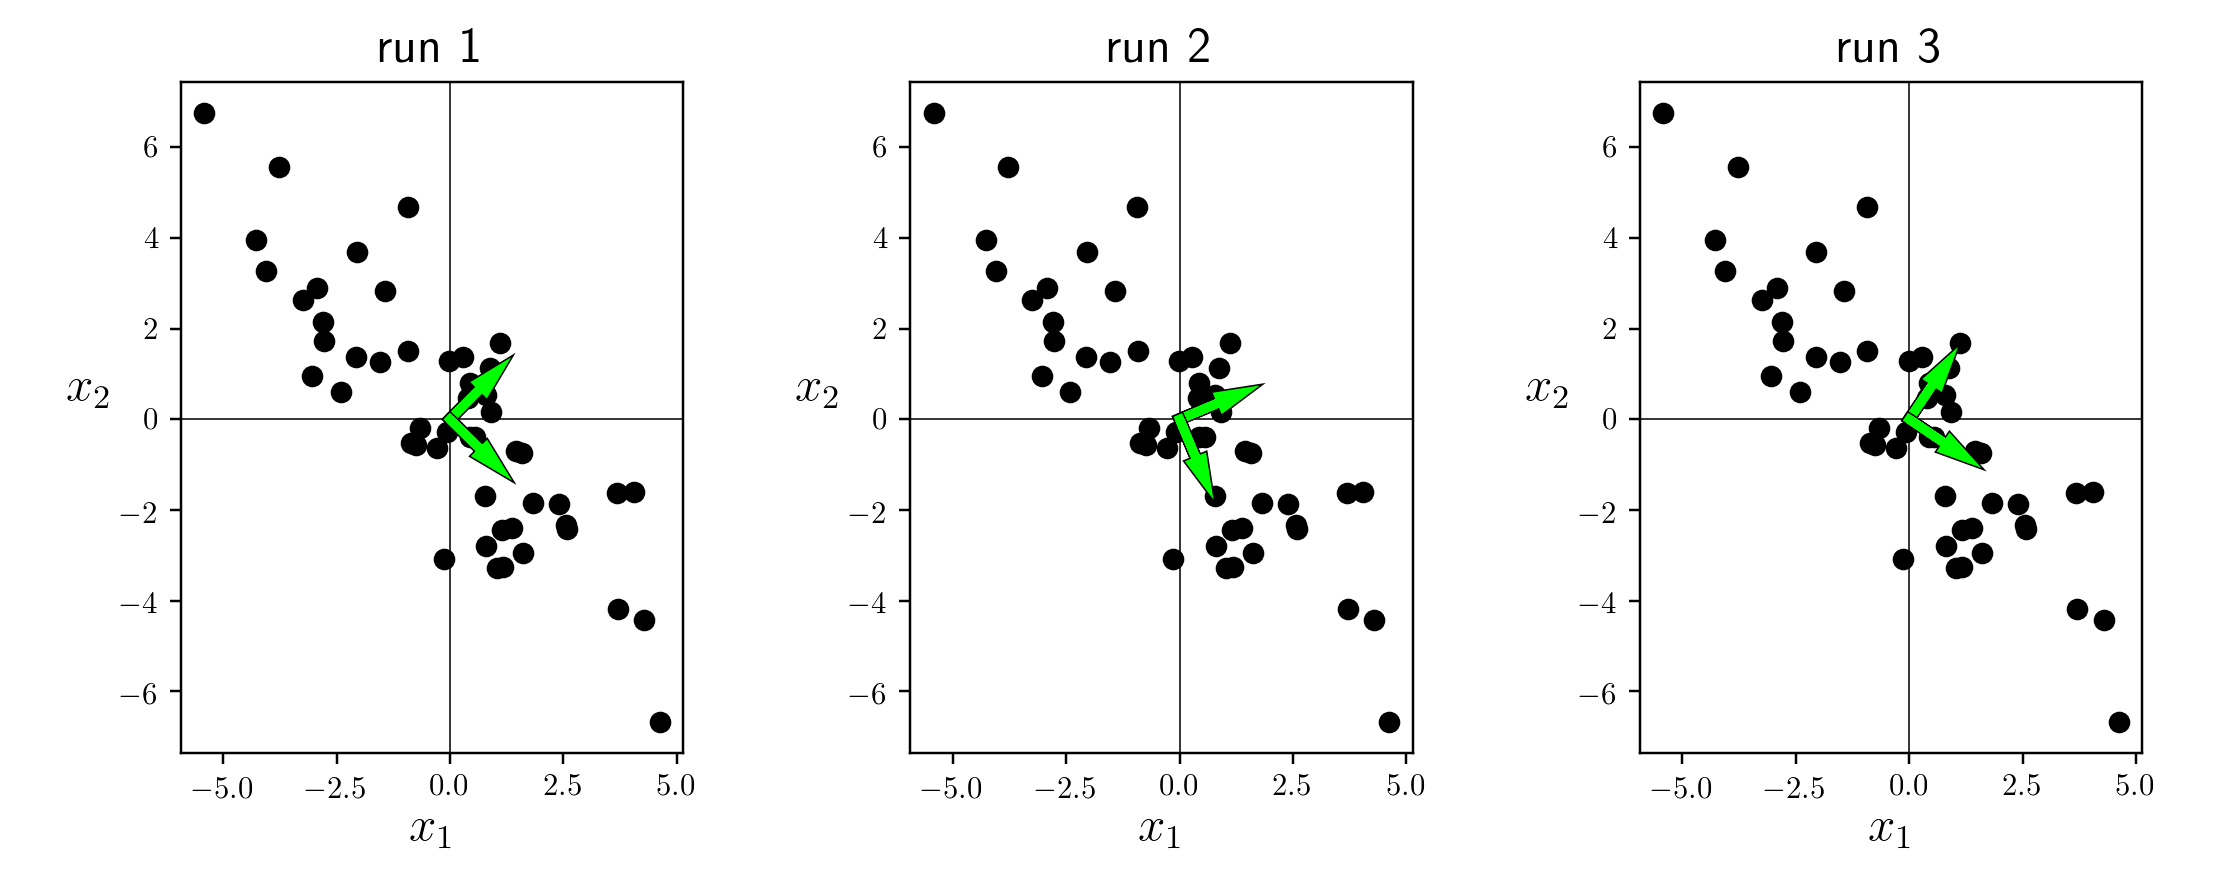

In [42]:
unlib.autoencoder_demos.visual_comparison(x,best_weights)

#### <span style="color:#a50e3e;">Example 2. </span>  Partial linear PCA via regression

In [43]:
# tune pca least squares cost
g = PCA_least_squares; alpha_choice = 3*10**(-4); max_its = 300; w = 0.1*np.random.randn(2,1);
w = np.array([-4.5,4.5])[:,np.newaxis]
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

<IPython.core.display.Javascript object>


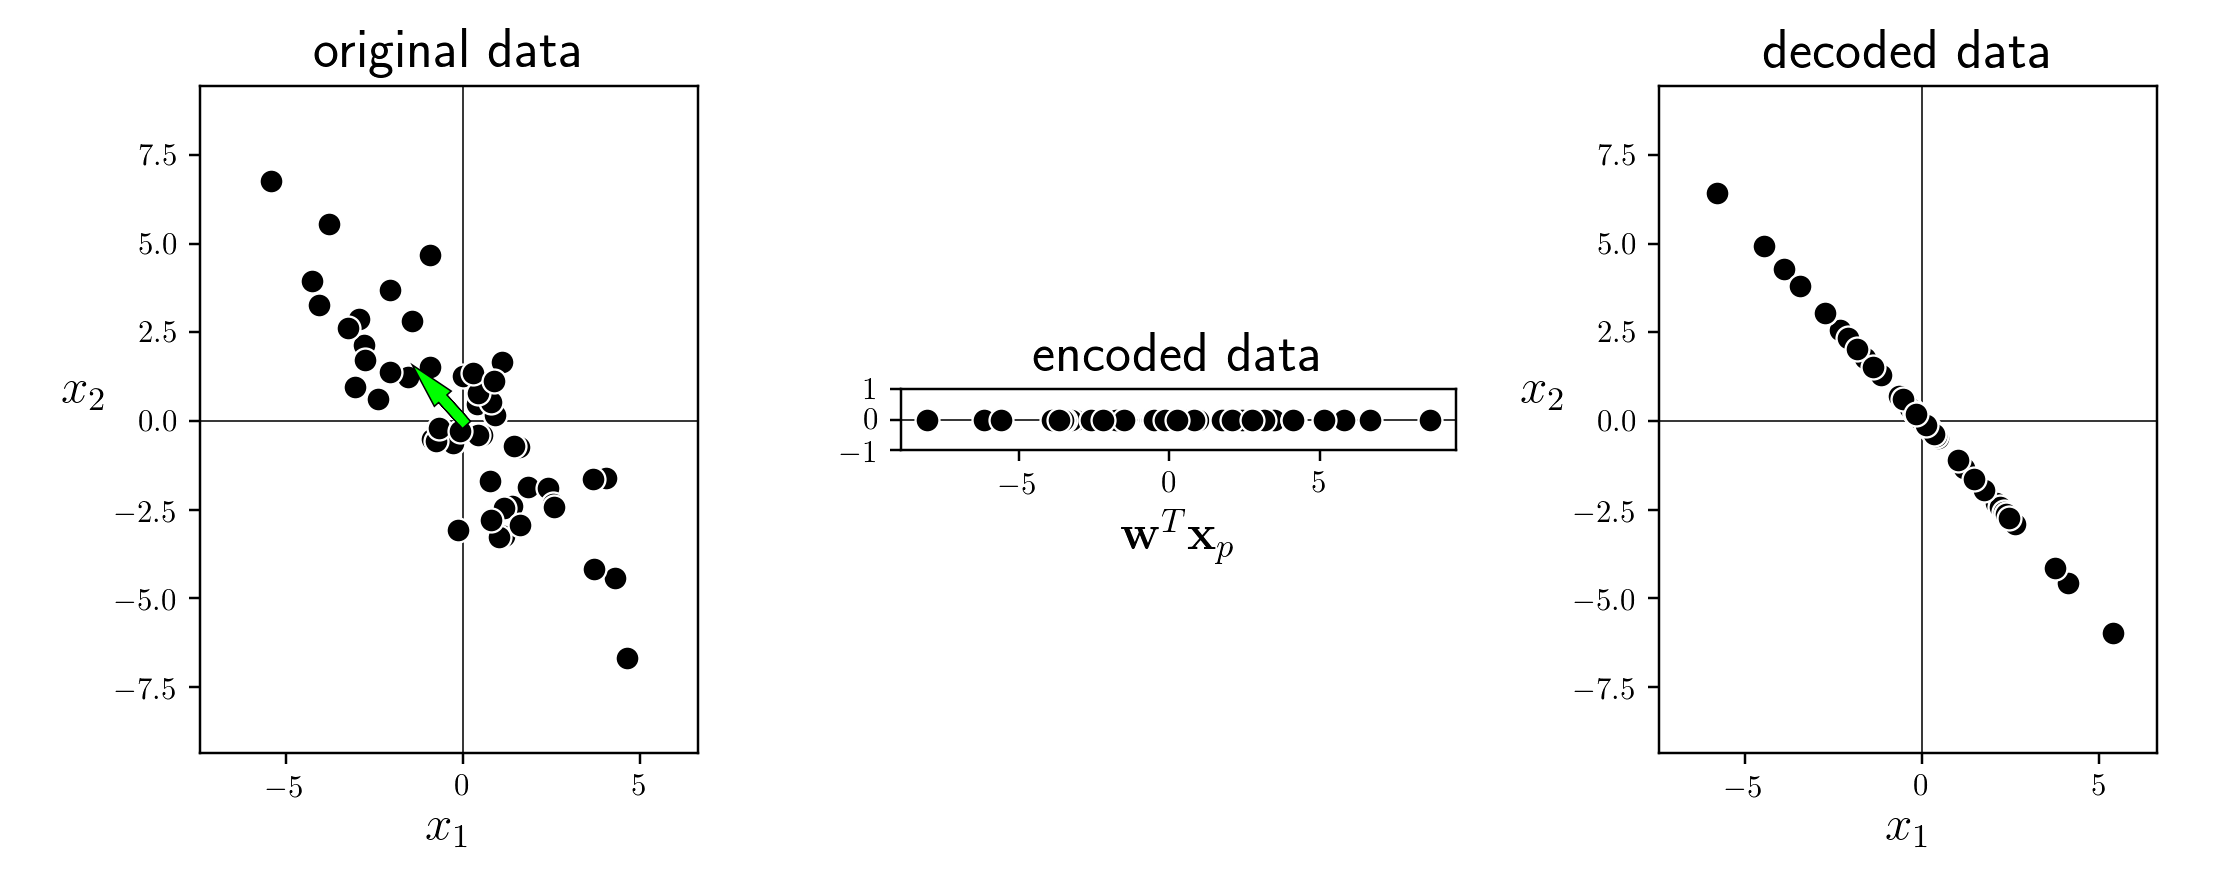

<IPython.core.display.Javascript object>


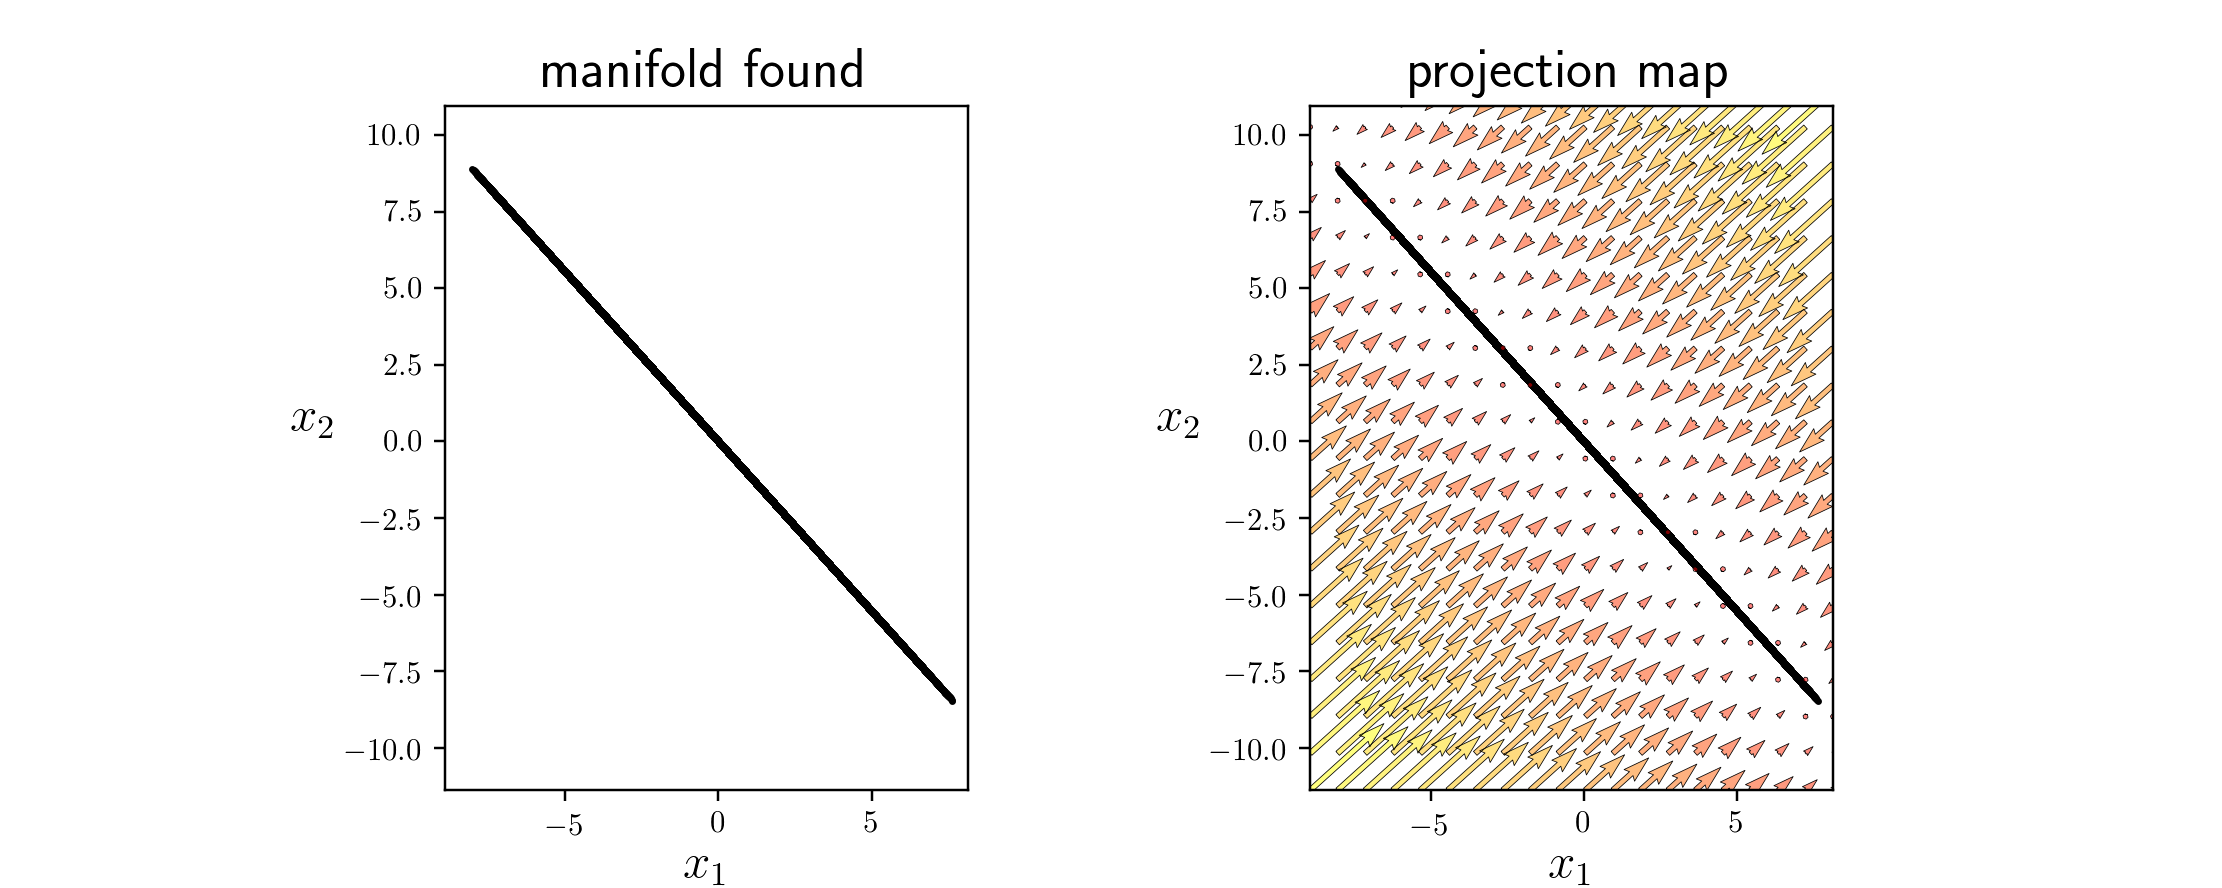

In [46]:
unlib.autoencoder_demos.show_encode_decode(x,encoder,decoder,cost_history_1,weight_history_1,show_pc = True,scale = 150,encode_label = r'$\mathbf{w}^T\mathbf{x}_p$')

<IPython.core.display.Javascript object>


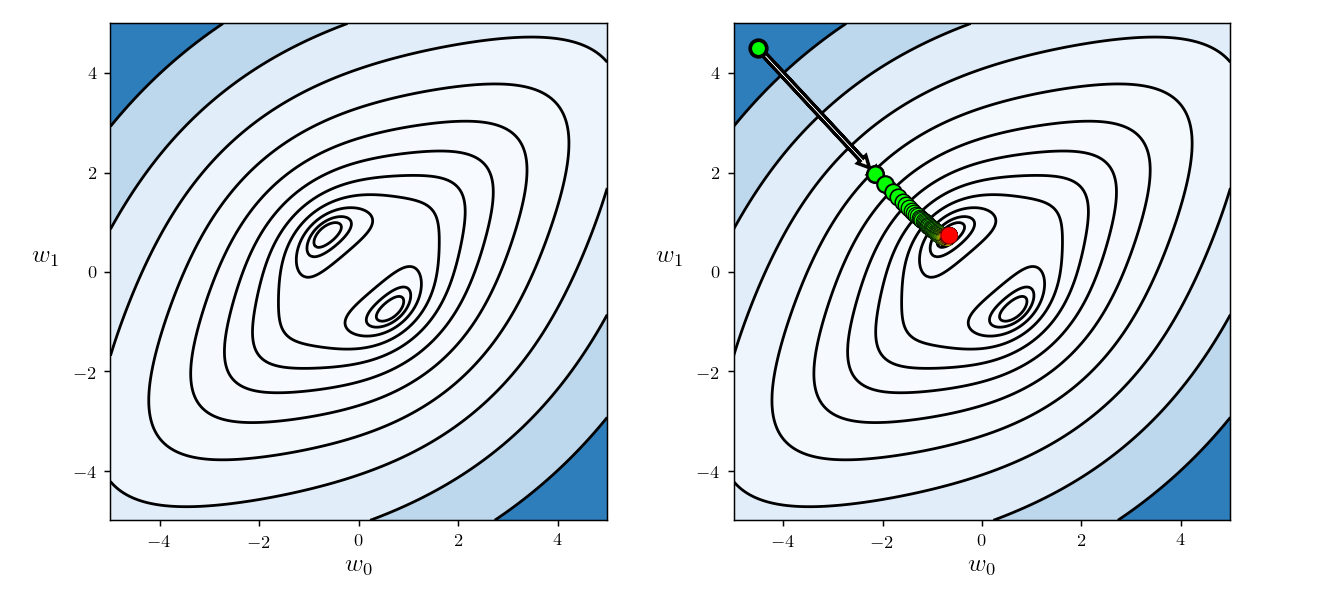

In [14]:
# show run on contour plot
static_plotter.two_input_contour_plot(PCA_least_squares,weight_history_1,xmin = -5,xmax = 5,ymin = -5,ymax = 5,num_contours = 11,show_original = True)

#### <span style="color:#a50e3e;">Example 1. </span> Circular case

In [2]:
x = np.loadtxt(datapath + 'circle_data.csv',delimiter=',')

<IPython.core.display.Javascript object>


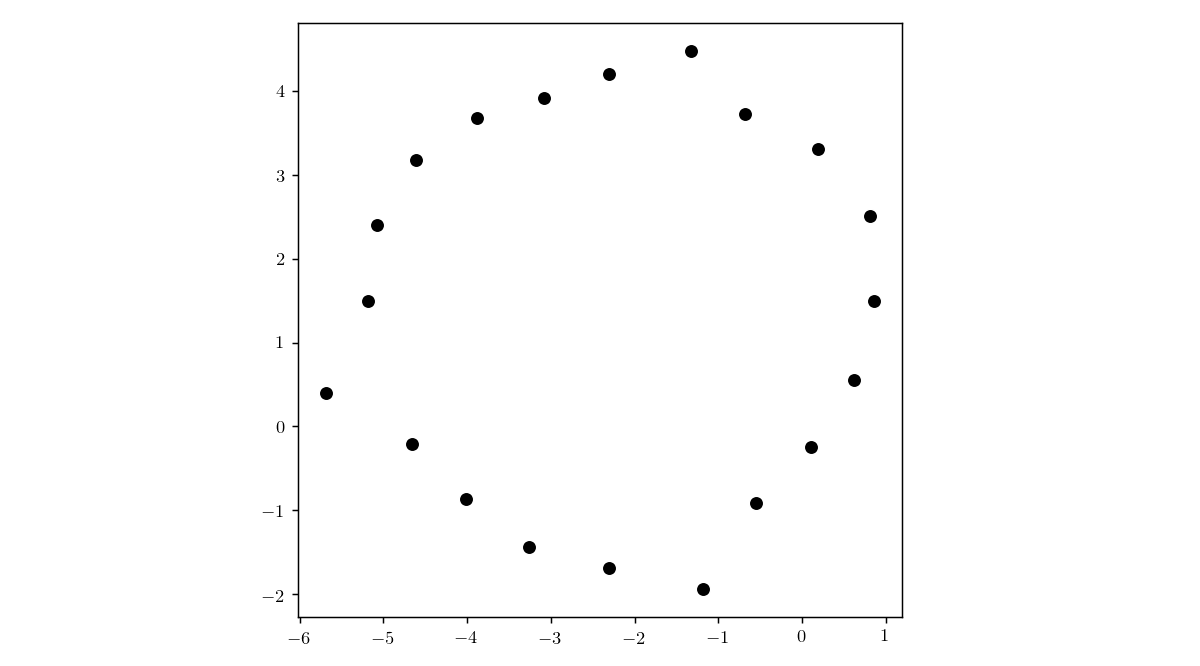

In [3]:
# # # create dataset
# num_pts = 21
# thetas = np.linspace(0,2*np.pi,num_pts)
# # thetas = 2*np.pi*np.random.rand(1,num_pts)
# noise = 0.25*np.random.randn(1,num_pts)
# radius = 3.1
# noise += radius
# x1 = noise*np.cos(thetas)[np.newaxis,:] - 2.3
# x2 = noise*np.sin(thetas)[np.newaxis,:] + 1.5

# x = np.vstack((x1,x2))
# x = x[:,:-1]

fig = plt.figure(figsize = (9,5))
gs = gridspec.GridSpec(1,1) 
ax1 = plt.subplot(gs[0],aspect = 'equal'); 
ax1.scatter(x[0,:],x[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')

In [4]:
# an implementation of the least squares cost function for linear regression
def PCA_least_squares(w):
    cost = np.sum((model(x,w) - x)**2)
    return cost/float(x.shape[1])

In [5]:
# compute linear combination of input point
def model(x,w):    
    # perform encoding 
    v = encoder(x,w[0])
    
    # perform decoding 
    a = decoder(w[1:],v)
    return a

In [6]:
def my_arctan(x,y):
    v = y/x
    if x > 0:
        return np.arctan(v)
    elif x < 0 and y >= 0:
        return np.arctan(v) + np.pi
    elif x < 0 and y < 0:
        return np.arctan(v) - np.pi
    elif x==0 and y > 0:
        return np.pi*0.5
    elif x==0 and y < 0:
        return -np.pi*0.5

In [7]:
def encoder(x,w):
    a = x - w     
    b = []
    for i in range(a.shape[1]):
        b.append(my_arctan(a[0][i],a[1][i]))
    b = np.array(b)
    return b

def decoder(w,v):
    a = w[0]*np.vstack((np.cos(v),np.sin(v))) + w[1]
    return a

In [8]:
g = PCA_least_squares;
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)]);

# tune pca least squares cost
alpha_choice = 10**(-1); max_its = 1000; 
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# pluck out best weights
ind = np.argmin(cost_history_1)
w_best = weight_history_1[ind]

<IPython.core.display.Javascript object>


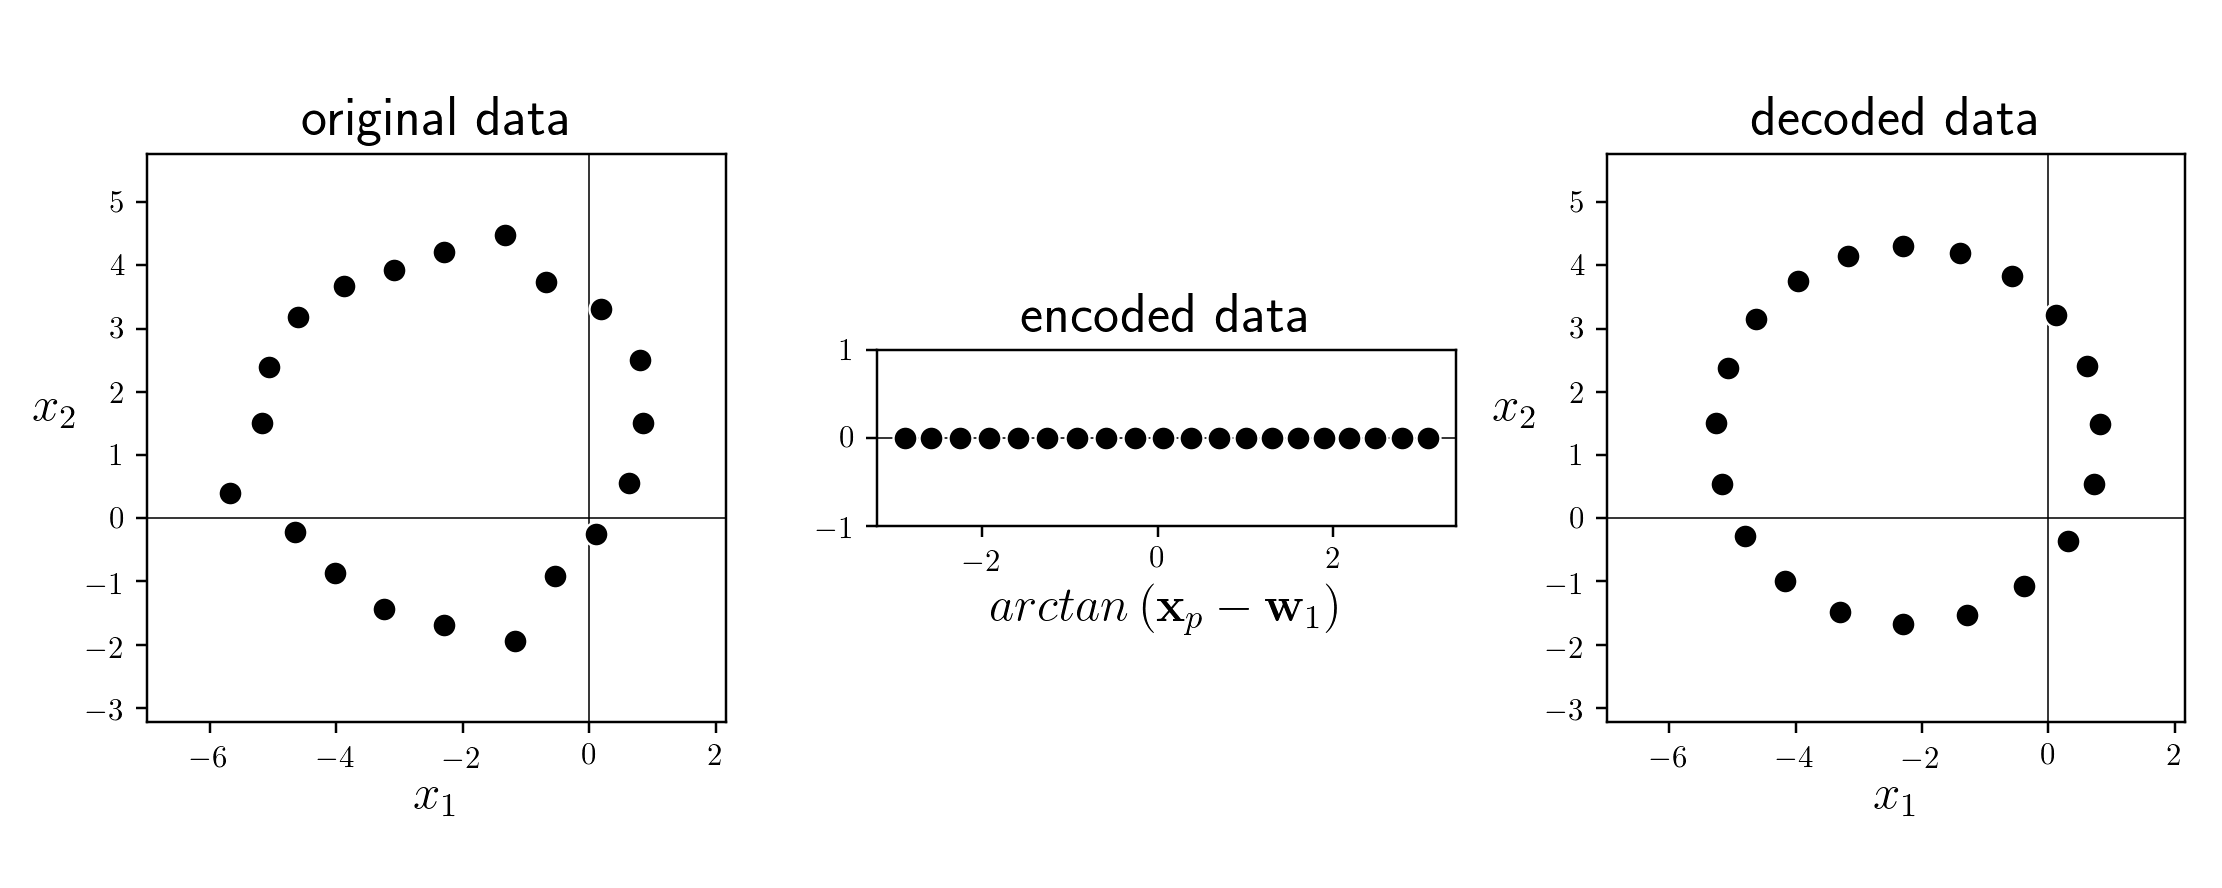

<IPython.core.display.Javascript object>


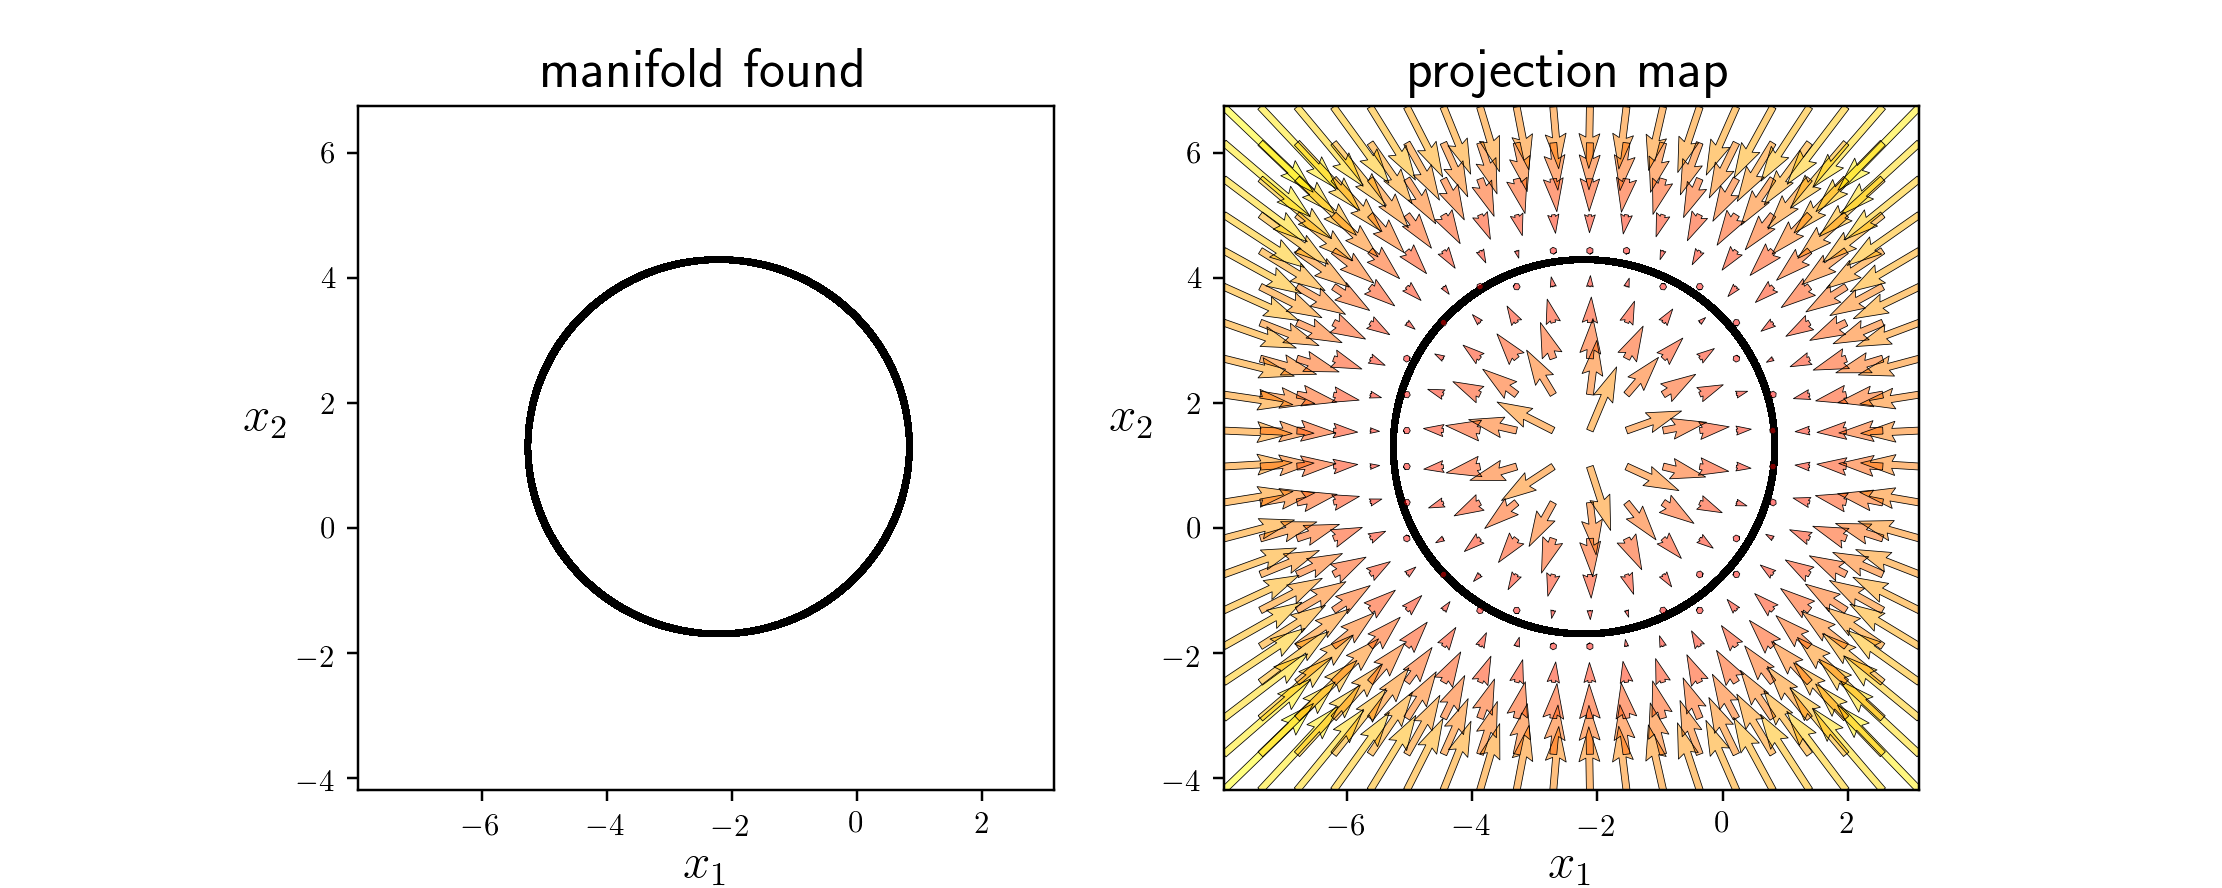

In [24]:
unlib.autoencoder_demos.show_encode_decode(x,encoder,decoder,cost_history_1,weight_history_1,scale = 55,encode_label = r'$\text{arctan}\left(\mathbf{x}_p - \mathbf{w}_1\right)$')

#### <span style="color:#a50e3e;">Example 1. </span>  K-means